# Linear Regression

In [1]:
!pip install d2l==1.0.3

In [ ]:
%matplotlib inline
# 그래프를 셀 아래 직접 표시해줌
import torch
from d2l import torch as d2l
# from A import B as C : A라는 패키지에서 B라는 서브모듈을 가져와서 C라는 이름으로 쓰겠다

## Defining the Model

- Initialize weights by drawing random numbers from a normal distribution with mean 0 and a standard deviation of 0.01
- set bias 0

In [3]:
class LinearRegressionScratch(d2l.Module):
# d2l.Module 기반으로 새 클래스 만든거 구조: class 클래스이름(부모클래스):
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
    # 클래스가 처음 만들어질 때 실행되는 초기화 함수. self는 클래스 자기자신 클래스안에서 선언한 변수는 self.변수명으로 써야함
    # 앞에 self는 이 클래스 자체를 가리키고, 뒤에 셋은 하이퍼파라미터 값
    # num_inputs: 입력 데이터 X의 특성 수 
    # lr: learning rate, 학습률 (크면 발산, 작으면 수렴 느림)
    # sigma=0.01: 정규분포에서 초기가중치 w를 뽑을 때의 표준편차
        super().__init__()
        # super는 부모 클래스인 d2l.module 의미, __init__은 부모클래스의 초기화함수
        self.save_hyperparameters()
        #__init__함수에 전달된 인자들 세개 자동으로 저장
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        # 평균 0, 표준편차 sigma인 정규분포에서 (num_inputs_1) 크기의 weight 텐서를 샘플링
        # requires_grad=True 학습가능하게 설정
        self.b = torch.zeros(1, requires_grad=True)
        # bias를 0으로 초기화
        # 얘도 학습가능하게 설정

- weight **w**, input features **X**, bias **b**(scalar)

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
# 데코레이터 forward 함수를 클래스 바깥에서 정의 but LinearRegressionScratch 클래스의 메서드로 자동 등록

def forward(self, X):
# forward: 모델이 입력 받아서 출력값 계산하는 핵심 함수
# X: 입력데이터 self 통해 self.w, self.b 에 접근 가능
    return torch.matmul(X, self.w) + self.b
    # torch.matmul: 선형결합(곱)
    # X: 입력행렬 (배치크기 X 특성수)
    # self.w: 가중치 행렬 (특성수 X 1)

## Defining the Loss Function

- transform true value y into the predicted value's shape y_hat
- averaged loss value를 최종결과로 return

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
# loss를 클래스 외부에서 정의하면서 LinearRegressionScratch 클래스에 연결
def loss(self, y_hat, y):
    l = (y_hat-y) ** 2
    return l.mean()
# 오차 제곱의 평균
# y_hat: 예측값
# y: 실제값

## Defining the Optimization Algorithm

과제는 아니지만, 전체적인 deep learning pipeline을 파악해주세요!

In [ ]:
class SGD(d2l.HyperParameters):
# SGD 클래스는 d2l.HyperParameters(부모 클래스)를 상속할 클래스이다
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
    # 파라미터, 학습률 저장
    # params: 학습할 파라미터들(ex: self.w, self.b)
    # lr: 학습률
        self.save_hyperparameters()
        # params,lr를 인스턴스에 저장 나중에 self.params, self.lr로 나중에 접근 가능하게 함

    def step(self):
    # 경사하강법 1 step 진행
        for param in self.params:
            param -= self.lr * param.grad 
            # 경사하강법 공식
            # param.grad: 파라미터에 대한 loss의 기울기(미분값)
    def zero_grad(self):
    # 누적된 gradient 초기화
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [ ]:
@d2l.add_to_class(LinearRegressionScratch)
# LinearRegressionScratch 클래스 안에 이 메서드 넣어줌
def configure_optimizers(self):
# 이 클래스를 사용해 optimizer 객체를 생성해줌
    return SGD([self.w, self.b], self.lr)

##Training

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


In [18]:

@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch
# 아무 작업도 하지 않고 그대로 배치를 반환

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
# 1 epoch 동안의 학습과 검증을 수행하는 루프

    self.model.train()
    # 모델을 학습 모드로 전환함
    for batch in self.train_dataloader:
    # 학습 데이터셋을 배치 단위로 순회하는 반복문
        loss = self.model.training_step(self.prepare_batch(batch))
        # prepare_batch로 전처리후 self.model.training_step로 loss계산
        # 하나의 배치에 대한 loss 계산하는 단계
        self.optim.zero_grad()
        # 파라미터의 기울기 초기화
        with torch.no_grad():
        # 자동 미분 끄는 기능
            loss.backward()
            # 방금 구한 loss값 기준 역전파 수행
            if self.gradient_clip_val > 0:  
            # gradient clipping 수행할지 결정
            # 값이 0보다 크면 clip 적용 (폭주하는 gradient 방지용)
                self.clip_gradients(self.gradient_clip_val, self.model)
                # 파라미터의 gradient norm이 일정 임계값 넘지 않도록 gradient clipping 수행
            self.optim.step()
            # 지금까지 계산한 gradient 이용해 파라미터 (w,b) 업데이트
        self.train_batch_idx += 1
        # 학습 배치 인덱스 값 1증가 시킴
    if self.val_dataloader is None:
        return
    # 검증을 위한 dataloader 없으면 학습만 수행하고 끝냄
    self.model.eval()
    # 모델을 평가 모드로 전환
    for batch in self.val_dataloader:
    # 검증 데이터셋을 배치 단위로 순회
        with torch.no_grad():
        # 검증 단계에서는 기울기 계산하지 않기 때문에 autograd 끔
            self.model.validation_step(self.prepare_batch(batch))
            # 검증용 손실이나 예측값 계산
        self.val_batch_idx += 1
        # 검증 배치 인덱스도 증가

loss를 확인해봅시다 !

In [19]:
model = LinearRegressionScratch(2, lr=0.03)
# 직접 구현한 선형 회귀 모델 클래스
# 2: 입력 특성 개수 
# lr=0.03 학습률
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)
# 직접만든 모델로 학습 loss, gradient, optimizer 전부 수행

ValueError: optimizer got an empty parameter list

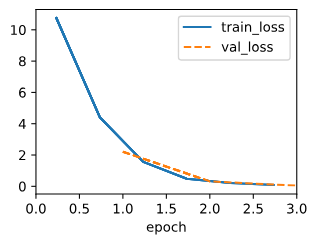

-정답 그림

# Softmax Regression

다양한 X를 설정해서 진행해주셔도 좋을 거 같습니다 :>

In [11]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)
# X.sum(0, keepdims=True): 열 기준 합침(각 열의 합) , 1행짜리 유지(shape이 (1,n))
# X.sum(1, keepdims=True): 행 기준 합침(각 행의 합) , 1열짜리 유지(shape이 (m,1))
# 합친 차원을 유지하지 않으면 broadcasting이 안 돼서 나눌 수가 없어.


(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

softmax를 구현해주세요

In [8]:
def softmax(X):
    #softmax 구현
    X_exp=torch.exp(X)  # 각 원소에 exp적용
    partition = X_exp.sum(dim=1,keepdim=True) # 행마다 합
    return X_exp / partition # broadcasting으로 각 원소를 그 행의 합으로 나눔

In [ ]:
X = torch.rand((2, 5)) # 크기가 (2,5)인 텐서 무작위 생성
X_prob = softmax(X)
# 소프트맥스 확률 분포 구하기
X_prob, X_prob.sum(1)

(tensor([[0.1551, 0.2475, 0.2000, 0.1634, 0.2340],
         [0.1306, 0.1758, 0.2766, 0.1646, 0.2524]]),
 tensor([1., 1.]))

## Model

- 28*28 pixel image를 가지고, flatten하여 vector로 만듦
- 10 class 존재

In [12]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
    # num_inputs: 입력 차원(ex:784), num_outputs: 클래스 수, lr: 학습률
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)
        #requires_grad=True: 학습가능하게 설정
    def parameters(self):
        return [self.W, self.b]
    # 모델이 학습할 파라미터 목록 반환, optimizer에 넘겨주기 위해 필요

In [13]:
@d2l.add_to_class(SoftmaxRegressionScratch)
# @: forward 함수 클래스에 붙여줌
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    # 입력이미지를 평탄화해서 2차원 텐서로 변형 
    return softmax(torch.matmul(X, self.W) + self.b)
    # 각 row를 확률로 변환 각 row의 합이 1이 되는 확률 벡터 출력

## Cross-Entropy Loss

다양한 y로 연습해보셔도 좋을 거 같습니다 :>

In [ ]:
y = torch.tensor([0, 2])
# 정답 클래스 인덱스 담은 텐서
# 첫 번째 샘플의 정답클래스 0, 두 번째 샘플의 정답 클래스는 2
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]
# 첫 샘플 클래스 0에 해당하는 확률: 0.1
# 두 번째 샘플 클래스 2에 해당하는 확률: 0.5

tensor([0.1000, 0.5000])

Cross entropy loss를 구현해주세요

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y]).mean()
    # y_hat[range(len(y_hat)),y]: 각행 마다 정답 클래스에 해당하는 확률 뽑아냄
cross_entropy(y_hat, y)

tensor(1.4979)

In [16]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

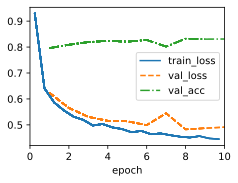

In [20]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
# num_inputs=784:28x28 이미지를 펼친 벡터 크기
# num_outputs=10: 클래스 수
trainer = d2l.Trainer(max_epochs=10)
# 10번 전체 데이터셋을 반복하여 학습
trainer.fit(model, data)
# 앞에 정의한 모델과 데이터를 학습 시작

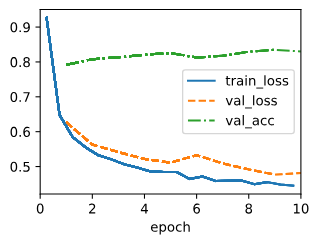
-정답 그림

## Prediction

어떤 방식으로 prediction 및 사진이 나오는지 확인해주세요

In [22]:
X, y = next(iter(data.val_dataloader()))
# data.val_dataloader(): 검증 데이터셋을 배치단위로 순회하는 dataloader
# X: 입력이미지, y: 정답레이블
preds = model(X).argmax(axis=1)
# model(X): 입력 이미지 X에 대한 모델의 출력값(로짓 or 확률)
# argmax(axis=1): 각 샘플마다 가장 높은 확률의 클래스 선택
preds.shape

torch.Size([256])

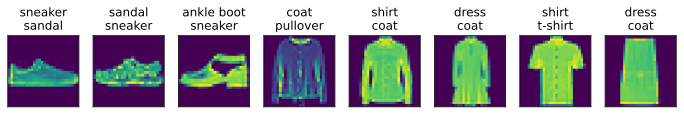

In [23]:
wrong = preds.type(y.dtype) != y
# 틀린 예측 찾기: 예측값과 정답이 다른 위치만 True인 boolean mask 생성
X, y, preds = X[wrong], y[wrong], preds[wrong]
# 틀린 샘플만 골라서 시각화 준비
# X: 틀리게 분류된 이미지, y: 해당 이미지의 정답, preds: 그 이미지에 대한 잘못된 예측
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
# data.text_labels(y): 정답 클래스의 텍스트 레이블
# data.text_labels(preds): 예측 클래스의 텍스트 레이블
# a+'\n'+b: 정답과 예측을 한 줄씩 표시
data.visualize([X, y], labels=labels)
# 시각화

In [24]:
# 실제 정답 sneaker 모델은 sandal로 예측함